<h1 style="color:#FF5733; text-align:center;">Proton Collision Classifier</h1>


# Introdução

O presente projeto, **Proton Collision Classifier (PCC)**, tem como objetivo desenvolver modelos de aprendizado de máquina capazes de prever o número de jatos de hádrons (nJets) produzidos em colisões de prótons. Para isso, utilizamos o dataset `MultiJetRun2010B`, oriundo do experimento CMS no CERN, que contém medições detalhadas de eventos de colisão.

Prever o número de jatos é relevante porque os jatos carregam informações essenciais sobre os processos fundamentais que ocorreram durante a colisão, permitindo a investigação de fenômenos físicos complexos, como a dinâmica de partículas quarks e glúons. Além disso, modelos capazes de estimar nJets com precisão podem auxiliar na seleção de eventos de interesse em experimentos de alta energia, otimizando recursos computacionais e focando na análise de colisões mais relevantes.

Outra motivação importante é a validação de teorias físicas, já que comparar as previsões dos modelos com os dados reais permite identificar discrepâncias e aprimorar os modelos teóricos. Dessa forma, o desenvolvimento de classificadores para nJets não só contribui para avanços em análise de dados de colisores, mas também fornece ferramentas úteis para experimentos futuros no estudo da física de partículas.

## Importações

Vamos começar importando as bibliotecas necessárias para os códigos do projeto. Utilizamos as bibliotecas `pandas` e `numpy` para a manipulação e análise do dataset, `matplotlib` para visualização de gráficos, e `optuna` para otimização de hiperparâmetros.

Do scikit-learn, usamos módulos para divisão dos dados, normalização, criação de pipelines, treinamento de modelos de classificação e avaliação de desempenho.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import seaborn as sns
from sklearn.linear_model import LogisticRegression


C:\Users\joao25017\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Tratamento de dados

Como visto na introdução, o dataset `MultiJetRun2010B`oriundo da CMS/CERN será utilizado. Contido nele há eventos de colisões de prótons com várias medições físicas detectadas, como:

`MR`: Escala de massa do evento

`Rsq`: Variável relacionada à energia e momento do evento

`E1`, `E2`: Energias dos dois jatos principais

`Px1`, `Py1`, `Pz1`, `Px2`, `Py2`, `Pz2`: Componentes do momento linear em cada direção espacial dos dois jatos

`HT`: Soma escalar dos momentos transversos de todos os jatos

`MET`: Energia transversal ausente – Missing Transverse Energy

A coluna `nJets` representa o número de jatos de hádrons detectados em cada colisão e será utilizado como target no processo de classificação.


In [2]:
pd.set_option("display.max_rows", 6)

df = pd.read_csv(r"Dataset\MultiJetRun2010B.csv")
df

,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,148029,388,302318745,215.553,0.031977,136.7100,-109.8930,-54.03420,-58.9032,142.1790,70.0254,41.1225,-116.5130,203.666,18.31100,2,0
1,148029,388,302323641,155.437,0.042157,83.3865,81.1500,6.88361,-12.9688,73.9025,-72.2472,11.8835,3.0899,154.659,14.77470,2,0
2,148029,388,302336217,400.563,0.026938,253.1840,139.9020,102.64000,-101.9350,535.5510,-110.3790,-89.0929,-516.1790,343.280,25.22110,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21723,149181,1804,1703621104,484.392,0.000920,197.1530,-61.5507,21.76930,110.9250,483.9510,47.5292,-37.9600,-470.8470,261.615,3.71479,4,0
21724,149181,1804,1703642752,215.713,0.055836,647.4060,-78.9546,-88.75690,636.3600,383.0890,80.5702,49.3765,371.1240,213.289,20.95540,2,0
21725,149181,1804,1703634776,547.384,0.001232,242.4140,191.2180,-118.75800,-37.2528,414.6670,-175.4890,83.3315,355.2330,444.869,1.84347,4,0


As colunas `Run`, `Lumi` e `Event` são apenas para identificação de eventos, então podemos retirá-las. O mesmo vale para a `nBJets` pois o mesmo não é relevante para o nosso trabalho.

Dessa forma, iremos definir apenas os dados que nos interessa como atributos, além de definir a `nJets` como target.

In [3]:
atributos = ["MR", "Rsq", "E1", "Px1", "Py1", "Pz1", "E2", "Px2", "Py2", "Pz2", "HT", "MET"]
target = ["nJets"]

df = df.reindex(atributos + target, axis=1)
df = df.dropna()
df

,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets
0,215.553,0.031977,136.7100,-109.8930,-54.03420,-58.9032,142.1790,70.0254,41.1225,-116.5130,203.666,18.31100,2
1,155.437,0.042157,83.3865,81.1500,6.88361,-12.9688,73.9025,-72.2472,11.8835,3.0899,154.659,14.77470,2
2,400.563,0.026938,253.1840,139.9020,102.64000,-101.9350,535.5510,-110.3790,-89.0929,-516.1790,343.280,25.22110,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21723,484.392,0.000920,197.1530,-61.5507,21.76930,110.9250,483.9510,47.5292,-37.9600,-470.8470,261.615,3.71479,4
21724,215.713,0.055836,647.4060,-78.9546,-88.75690,636.3600,383.0890,80.5702,49.3765,371.1240,213.289,20.95540,2
21725,547.384,0.001232,242.4140,191.2180,-118.75800,-37.2528,414.6670,-175.4890,83.3315,355.2330,444.869,1.84347,4


Antes de continuarmos, é necessário observar algo sobre o target.

In [4]:
contagem = df["nJets"].value_counts()
print(contagem)

porcentagem = df["nJets"].value_counts(normalize=True) * 100
print(porcentagem)

nJets
2    14002
3     6204
4     1325
5      169
6       23
7        3
Name: count, dtype: int64
nJets
2    64.448127
3    28.555648
4     6.098684
5     0.777870
6     0.105864
7     0.013808
Name: proportion, dtype: float64


Note que as classes de contagem de jets "4" pra cima possuem uma frequência muito baixa, sendo praticamente irrelevantes para o treinamento futuro. Portanto, podemos agrupá-lás para amenizar isso.

In [5]:
df["nJets"] = df["nJets"].apply(lambda x: x if x <= 3 else 4)

contagem = df["nJets"].value_counts()
print(contagem)
porcentagem = df["nJets"].value_counts(normalize=True) * 100
print(porcentagem)

nJets
2    14002
3     6204
4     1520
Name: count, dtype: int64
nJets
2    64.448127
3    28.555648
4     6.996226
Name: proportion, dtype: float64


Dessa forma, a classe "4" para os `nJets` passa a indicar "4 ou mais" jets detectados.

Perceba que ainda há um desbalanceamento na frequência das classes. Isso pode afetar de maneira negativa os modelos, pois ele tende a aprender mais sobre a classe majoritária e ignorar as minoritárias. 

Para corrigir isso, utilizaremos de técnicas de `atribuição de pesos de classe`, dando mais importância às classes minoritárias durante o treinamento. Esse conceito será melhor explicado mais à frente do trabalho.

### Split dos dados

A forma como dividimos os dados entre treino e teste também deve ser cuidadosamente definida, garantindo que todos os modelos sejam avaliados de maneira justa. A semente aleatória atua como um hiperparâmetro que deve ser fixado antes do treinamento, assegurando que a divisão dos dados e quaisquer processos aleatórios sejam consistentes entre diferentes execuções. Embora não influencie diretamente a acurácia do modelo, ela é fundamental para reprodutibilidade dos resultados. 

Para este estudo, iremos reservar 20% dos dados para teste, enquanto o restante será alocado para treino. Além disso, manteremos a proporção das classes de `nJets` equilibrada entre os conjuntos de treino e teste utilizando o argumento `stratify`.

In [6]:
semente_aleatoria = 2307
tamanho_teste = 0.2

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=tamanho_teste, random_state=semente_aleatoria, stratify=df["nJets"]
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino[atributos].values
y_treino = df_treino[target].values.ravel()

X_teste = df_teste[atributos].values
y_teste = df_teste[target].values.ravel()


Usaremos o `StandardScaler` para normalizar os atributos, transformando-os para que tenham média zero e desvio padrão 1. Isso evita que variáveis com escalas maiores dominem o modelo e garante que algoritmos sensíveis à magnitude dos dados funcionem de maneira eficiente.

In [7]:
scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)
X_teste = scaler.transform(X_teste)

# Treinamento dos modelos

## Métrica de desempenho

A métrica escolhida para avaliar o desempenho dos modelos foi o `F1-score weighted`. Primeiramente, o `F1-score` é uma métrica que combina precisão (precision) e revocação (recall).

**Precisão** refere-se à fração de valores que foram corretamente identificados com um determinado rótulo em relação a todos os valores que foram corretamente identificados.

Já **revocação** refere-se a quantos valores com determinado rótulo foram corretamento identificados considerando todos que possuem esse rótulo.

Através da média harmônica entre precision e recall, encontra-se o `F1-score`:

$$
F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

A sua versão ponderada (`F1-score weighted`) tem como diferencial o fato de que ela leva em conta a frequência de cada classe no conjunto de dados ao calcular o valor final. Dessa forma, o impacto das classes com mais exemplos é proporcionalmente maior, o que torna a métrica mais representativa em problemas com classes desbalanceadas. Essa variação é dada por:

$$
F1_{weighted} = \sum_{i=1}^{n} w_i \times F1_i
$$

Onde,

$$
w_i = \frac{\text{Número de amostras na classe } i}{\text{Número total de amostras}}
$$

## Árvore de Decisão

A árvore de decisão é um algoritmo de classificação  que organiza os dados em uma estrutura hierárquica de divisões, onde cada nó separa os exemplos em subconjuntos menores com base nos atributos disponíveis. Esse processo continua até atingir as folhas, que representam a classe final prevista para cada exemplo [Figura 1].

O funcionamento da árvore consiste em analisar todos os dados disponíveis e, em cada nó, realizar a divisão que melhor separa as classes de acordo com um critério de impureza. Cada divisão cria novos nós, e o processo se repete até que não haja mais subdivisões necessárias, determinando a classe predita em cada folha.

<figure style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ComicDeath/Proton-Collision-Classifier/main/Figuras/decision-tree.png" alt="Estrutura comum da decision tree" width="600">
  <figcaption><b>Figura 1.</b> Estrutura comum de uma árvore de decisão.</figcaption>
  <br>
  <figcaption><b>Fonte:</b> Christonasis Antonios Marios - traintestsplit.com</figcaption>
</figure>
<br>

Em nosso trabalho, iremos treinar um modelo de Árvore de Decisão para prever `nJets` a partir de atributos físicos das colisões de prótons. Para isso, utilizaremos um `pipeline` que inclui padronização dos dados, e faremos otimização de hiperparâmetros com o Optuna para obter o melhor desempenho do modelo, levando em consideração também o desbalanceamento das classes por meio de pesos.

------------------------------------------------------------------------------------------------------------------

Quando trabalhamos com classes desbalanceadas, o modelo pode ficar tendencioso para a classe majoritária. Isso acontece porque, sem ajustes, o algoritmo não penaliza suficientemente os erros das classes minoritárias, que são menos representadas nos dados.

O parâmetro `class_weight="balanced"` corrige isso atribuindo pesos inversamente proporcionais à frequência das classes. Ou seja, quanto menos frequente a classe, maior será o seu peso na função de aprendizado, fazendo com que classes minoritárias sejam mais consideradas pelo modelo.

------------------------------------------------------------------------------------------------------------------

Fora isso, a abordagem do `pipeline` facilita a execução de várias etapas de pré-processamento e modelagem em sequência, permitindo que padronizemos o fluxo de trabalho e apliquemos transformações nos dados de forma consistente e automatizada, sem repetições desnecessárias. Inicialmente, aplicaremos o `StandardScaler()` para padronizar os dados, garantindo que todas as variáveis estejam na mesma escala antes de ajustar o `DecisionTreeClassifier`, o que ajuda o modelo a aprender de forma mais eficiente.

In [8]:
modelo_ad_pipeline = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=semente_aleatoria, class_weight="balanced")
)

### Estimativa de desempenho

Para estimarmos o desempenho do modelo, utilizamos o `StratifiedKFold` nos dados de X_treino e y_treino. Essa técnica de validação cruzada divide o conjunto de treino em vários folds, mantendo em cada um deles a mesma proporção de classes presente no dataset original. Dessa forma, evitamos que alguma classe minoritária fique sub-representada em algum fold, o que poderia distorcer a avaliação do modelo.

In [9]:
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)

metricas = cross_val_score(
    modelo_ad_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

estimativa_ad = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", estimativa_ad)

Valor do F1_weighted em cada fold: [0.71911223 0.71946067 0.69216612 0.7070916  0.70080966 0.68764985
 0.7026415  0.71007314 0.7112263  0.70233485]
Valor médio 0.7052565920755243


### Otimização utilizando Optuna

O `Optuna` é uma biblioteca de otimização de hiperparâmetros que permite encontrar automaticamente as melhores combinações para algoritmos de machine learning. O processo começa com a definição de uma função objetivo, que especifica os hiperparâmetros a serem testados e o modelo a ser treinado. Em seguida, o Optuna explora de forma eficiente o espaço de hiperparâmetros, avaliando diferentes configurações com base em uma métrica de desempenho escolhida.

Definiremos uma função `cria_instancia_modelo_ad(trial)`, que irá utilizar do `Optuna` para sugerir valores de hiperparâmetros da Árvore de Decisão Classificadora.

In [10]:
def cria_instancia_modelo_ad(trial):
    
    parametros_ad = {
        "criterion": trial.suggest_categorical(
            "criterion", ["gini", "entropy", "log_loss"]
        ),  
        # Define a função usada para medir a qualidade de uma divisão. "gini" = índice de Gini, "entropy" = ganho de informação, "log_loss" = logaritmo da perda de entropia
        
        "max_depth": trial.suggest_int("max_depth", 2, 30),  
        # Profundidade máxima da árvore
        
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),  
        # Número mínimo de amostras necessárias para dividir um nó interno
        
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),  
        # Número mínimo de amostras que um nó folha deve ter
        
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),  
        # Número máximo de características consideradas para dividir um nó. None = todas, "sqrt" = raiz quadrada, "log2" = logaritmo base 2
        
        "class_weight": "balanced",  
        # Ajusta os pesos das classes inversamente proporcionais à frequência
        
        "random_state": semente_aleatoria  
        # Define a semente aleatória para reprodutibilidade dos resultados
    }

    modelo = DecisionTreeClassifier(**parametros_ad)
    return modelo

Criaremos agora a função `objetivo_ad`, responsável por avaliar o desempenho do modelo com diferentes combinações de hiperparâmetros sugeridas pelo Optuna nos trials, utilizando validação cruzada e a métrica F1-weighted.

In [11]:
def objetivo_ad(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_ad(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()

Criaremos agora o objeto de estudo do `Optuna`, podendo armazenar o resultado da otimização e reutilizá-los depois sem precisar realizar o processo novamente. Além disso, o estudo será utilizado para defirmos alguns parâmetros de otimização, como a direção de maximização da métrica F1-weighted.

In [12]:
nome_do_estudo = "decision_tree_nJets"
pasta = "Estudos do Optuna"
caminho_db = f"{pasta}/{nome_do_estudo}"


study_ad = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///{caminho_db}.db", 
    load_if_exists=True
)

[I 2025-11-04 08:10:12,224] Using an existing study with name 'decision_tree_nJets' instead of creating a new one.


A função `objetivo_parcial_ad` é uma adaptação da função original feita para que o `Optuna` consiga executar o processo de otimização de forma mais simples. Nela, os dados de treinamento (X_treino e y_treino) e o número de folds (num_folds) já ficam definidos, enquanto o Optuna altera apenas o parâmetro trial a cada iteração, permitindo que diferentes combinações de hiperparâmetros sejam avaliadas automaticamente.

In [13]:
def objetivo_parcial_ad(trial):
    return objetivo_ad(trial, X_treino, y_treino, num_folds)

Com todas as funções definidas, o próximo passo é executar o `Optuna` para realizar a otimização dos hiperparâmetros. Definimos 100 tentativas (trials), nas quais o `Optuna` irá testar diferentes combinações de parâmetros do modelo, avaliando o desempenho em cada uma delas para, ao final, selecionar automaticamente aquela que apresentar os melhores resultados.

In [14]:
num_tentativas = 100
trials_ja_feitos = len(study_ad.trials)
if trials_ja_feitos < num_tentativas:
    study_ad.optimize(objetivo_parcial_ad, n_trials=num_tentativas - trials_ja_feitos)

In [15]:
print("Melhores hiperparâmetros encontrados:")
print(study_ad.best_params)
print(f"Número do melhor trial: {study_ad.best_trial.number}")
print(f"Melhor valor de F1: {study_ad.best_value}")

Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}
Número do melhor trial: 14
Melhor valor de F1: 0.7132023542986157


### Avaliação de desempenho

Criaremos agora um `pipeline` que combina o `StandardScaler` para normalizar os dados com a instância do modelo de árvore de decisão configurada com os melhores hiperparâmetros encontrados pelo `Optuna`. Em seguida, treinaremos esse pipeline nos dados de treino e avaliaremos seu desempenho no conjunto de teste, utilizando a métrica `F1_weighted` para medir a performance do modelo levando em conta o desbalanceamento das classes.

In [16]:
modelo_ad_pipeline = make_pipeline(
    StandardScaler(),  
    DecisionTreeClassifier(random_state=semente_aleatoria, **study_ad.best_trial.params, class_weight="balanced")
)

modelo_ad_pipeline.fit(X_treino, y_treino)

y_pred = modelo_ad_pipeline.predict(X_teste)

f1_ad_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_ad_final)

F1-score ponderado final: 0.7135445154439206


Também podemos visualizar o resultado por meio de uma matriz de confusão, cuja estrutura permite comparar os valores previstos com os reais. Essa ferramenta evidencia os acertos e erros do modelo, facilitando a identificação de padrões de classificação incorreta.

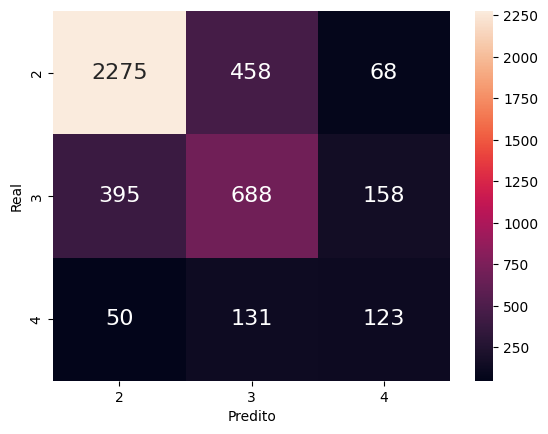

In [17]:
ordem_labels = df["nJets"].unique().tolist()


matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)
eixo = sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, fmt="d")
eixo.set(xlabel="Predito", ylabel="Real");
 

Nota-se que a maior parte das previsões corretas ocorre na classe 2, com 2275 acertos, enquanto as classes 3 e 4 apresentam maior dispersão de erros. Isso ocorre pois a classe 2 apresenta mais exemplos no conjunto de dados, o que faz o modelo aprender melhor seus padrões. Já as demais classes têm menos amostras, resultando em menor precisão nas previsões.

### Explicação do modelo

Para extrair informações do modelo e explicá-lo utilizaremos do `Permutation Importance`. 

O Permutation Importance é uma técnica usada para medir a importância de cada variável em um modelo preditivo. A ideia básica é avaliar quanto a performance do modelo piora quando os valores de uma variável específica são embaralhados (permutados), destrichando a relação dessa variável com a saída. Se a métrica de desempenho do modelo cair significativamente após a permutação, isso indica que a variável é importante para a predição. Por outro lado, se a métrica permanecer quase igual, a variável provavelmente tem pouca influência no modelo. Esse método é particularmente útil porque pode ser aplicado a qualquer modelo, mesmo aqueles que não fornecem diretamente medidas internas de importância dos atributos.

Importância das features (Permutation Importance):
HT: 0.23948038096102842
MR: 0.049729075679199555
Py2: 0.04898259469253903
Px2: 0.04811987824680501
Px1: 0.040424269309331115
Py1: 0.037483728198782054
E1: 0.03424237039852516
Pz1: 0.027488953300243348
E2: 0.018118303227126244
Rsq: 0.015613185720469037
MET: 0.005371236608311292
Pz2: 0.004909242592274587


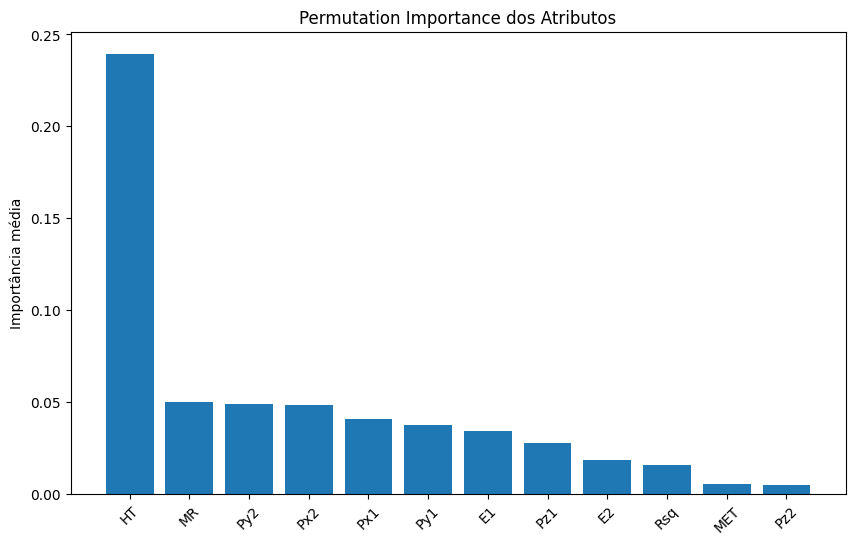

In [18]:
resultado_perm = permutation_importance(
    modelo_ad_pipeline,
    X_teste,
    y_teste,
    n_repeats=5,
    random_state=semente_aleatoria,
    scoring="f1_weighted",
    n_jobs=-1
)

importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1]  

tabela_importancia1 = pd.DataFrame({
    "atributo": np.array(atributos)[indices],
    "importancia_media": importancia_atributos[indices]
})

print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")

plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()

Observa-se que o atributo HT apresenta disparadamente a maior importância média, indicando ser o principal fator nas previsões. Os demais atributos, como MR, PX2 e PY2, possuem contribuições bem menores, sugerindo que o modelo depende fortemente de HT para distinguir as classes.

Isso provavelmente acontece porque o HT concentra informações mais relevantes ou com maior variação entre as classes, facilitando a distinção feita pelo modelo. Em outras palavras, ele tem maior poder discriminativo.

## K-NN

O algoritmo K-NN calcula a distância entre todos os pontos e aquele cujo target se deseja prever, utilizando um número determinados de pontos mais próximos, chamado "vizinhos", para fazer uma previsão com base em uma estatística aplicada neles. Nesse caso, que é o do classificador K-NN, essa estatística é a moda, ou seja, a previsão será igual à classe que mais se repete dentre dos vizinhos. [Figura 2]

Além disso, o desempenho do K-NN depende fortemente da escolha do número de vizinhos (k) e da métrica de distância utilizada. Valores pequenos de k podem tornar o modelo sensível a ruídos e outliers, enquanto valores muito grandes podem suavizar demais as diferenças entre classes, prejudicando a precisão.

<figure style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ComicDeath/Proton-Collision-Classifier/main/Figuras/knn.jpg" alt="Estrutura comum do KNN" width="600">
  <figcaption><b>Figura 2.</b> Estrutura comum do KNN.</figcaption>
  <br>
  <figcaption><b>Fonte:</b> Harris Amjad - mssqltips.com</figcaption>
</figure>
<br>

Da mesma forma que no modelo anterior, cria-se um `pipeline` contendo o normalizador padrão e o `KNeighborsClassifier`.

In [19]:
modelo_knn_pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

### Estimativa de desempenho

Para uma estimativa inicial de desempenho, é feita validação cruzada `StratifiedKFold` que procura manter a proporção entre as classes do target.

In [20]:
metricas = cross_val_score(
    modelo_knn_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

estimativa_knn = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", estimativa_knn)

Valor do F1_weighted em cada fold: [0.65236901 0.65097965 0.64570818 0.65459644 0.6483495  0.64239365
 0.67384852 0.65969269 0.66440267 0.64507859]
Valor médio 0.653741890824304


### Otimização utilizando Optuna

A função `cria_instancia_modelo_knn` instancia o modelo utilizando um _trial_ de hiperparâmetros:

In [21]:
def cria_instancia_modelo_knn(trial):
    
    parametros_knn = {
        "n_neighbors": trial.suggest_int("n_neighbors", 1,10000,log=True),
        # Número de vizinhos que são considerados para a previsão

        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        # Determinar se deve ser atribuído um peso maior aos vizinhos, dentre os sendo considerados, mais próximos em comparação aos mais distantes.
        
        "p": trial.suggest_float("p", 1, 2),
        # Distância de Minskowski - quando p=1, a distância equivale à de Manhattan, quando p=2, a distância é euclidiana

        "n_jobs": -1
    }

    modelo = KNeighborsClassifier(**parametros_knn)
    return modelo


A função objetivo é responsável por testas os diferentes conjuntos de hiperparâmetros, além d erealizar validação cruzada _k_-fold a fim de estimar de forma mais acurada o desempenho.

In [22]:
def objetivo_knn(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_knn(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()


Cria-se um estudo do `optuna` para a realização desses testes:

In [23]:
nome_do_estudo = "knn_nJets"

study_knn = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///Estudos do Optuna/{nome_do_estudo}.db", 
    load_if_exists=True
)

[I 2025-11-04 08:10:45,824] Using an existing study with name 'knn_nJets' instead of creating a new one.


É definida a função `objetivo_parcial_knn` pois o `optuna` só roda o estudo quando a função apresenta apenas um único argumento.

In [24]:
def objetivo_parcial_knn(trial):
    return objetivo_knn(trial, X_treino, y_treino, num_folds)

Procura-se, então, o melhor conjunto de hiperparâmetros dentre 100 tentativas.

In [25]:
trials_ja_feitos = len(study_knn.trials)
if trials_ja_feitos < num_tentativas:
    study_knn.optimize(objetivo_parcial_knn, n_trials=num_tentativas - trials_ja_feitos)

print("Melhores hiperparâmetros encontrados:")
print(study_knn.best_params)
print(f"Número do melhor trial: {study_knn.best_trial.number}")

Melhores hiperparâmetros encontrados:
{'n_neighbors': 6, 'weights': 'distance', 'p': 1.8587925569678725}
Número do melhor trial: 13


É, então, criado um `pipeline` com esse modelo com esses parâmetros otimizados, cujo desempenho é avaliado.

In [26]:
modelo_knn_pipeline = make_pipeline(
    StandardScaler(),  
    KNeighborsClassifier(**study_knn.best_trial.params)
)

modelo_knn_pipeline.fit(X_treino, y_treino)

y_pred = modelo_knn_pipeline.predict(X_teste)

f1_knn_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_knn_final)


F1-score ponderado final: 0.6553036651387504


Utiliza-se uma matriz de confusão para análise mais detalhada das previsões.

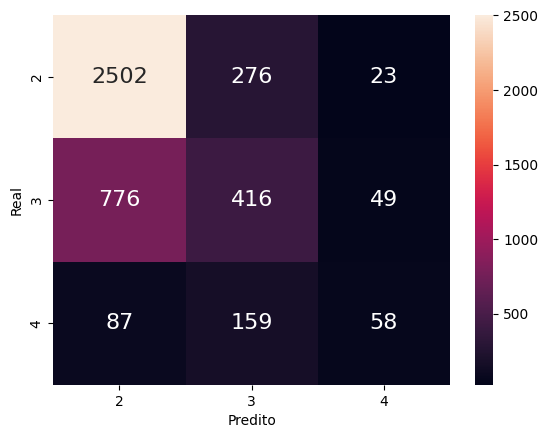

In [27]:
matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)
eixo = sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, fmt="d")
eixo.set(xlabel="Predito", ylabel="Real");

Nela, percebe-se que o modelo tende a prever corretamente o target quando o número de jet é igual a 2. Entretanto, para 3 e, principalmente, 4 jets, o modelo se mostra bastante falho, errando mais do que acertando. No caso de 4 jets, nota-se que são previstos outros valores muito mais do que o real. Isso pode ser característico do modelo, o qual apresentou um desempenho mediano, ou então resultado da desproporcionalidade entre as classes.

### Explicação do modelo

Pode-se também utilizar a `Permutation Importance` dos atributos visando compreender quais influenciaram mais o modelo.

Importância das features (Permutation Importance):
HT: 0.12028358699303925
Py2: 0.014399506382234483
Px2: 0.011018539252601323
Px1: 0.01096645500623621
E2: 0.00971503478416973
Py1: 0.0060792404341525556
E1: 0.005994357256686333
Rsq: 0.003340835560490496
MET: 0.00204153253119832
Pz2: 0.001400863388000584
MR: 0.0011036932802146238
Pz1: -0.008494729056439864


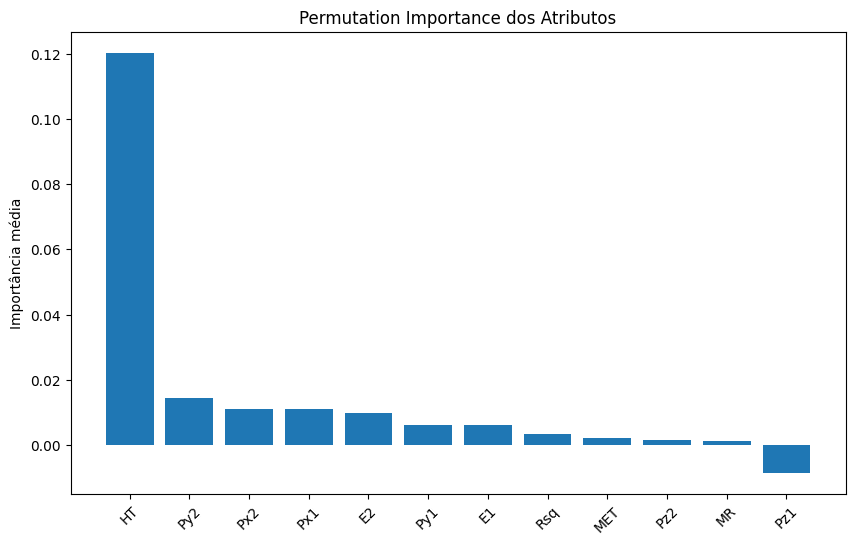

In [28]:
resultado_perm = permutation_importance(
    modelo_knn_pipeline,
    X_teste,
    y_teste,
    n_repeats=5,
    random_state=semente_aleatoria,
    scoring="f1_weighted",
    n_jobs=-1
)

importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1]  

tabela_importancia2 = pd.DataFrame({
    "atributo": np.array(atributos)[indices],
    "importancia_media": importancia_atributos[indices]
})

print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")

plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()


Nota-se que o atributo HT é indispensável para o êxito do modelo, enquanto os outros atributos apresentam contribuição diminuta em comparação. Isso se mostra não apenas como característica do modelo, aparentando ser intrínseco ao dataset desproporcional já que, no modelo anterior (árvore de decisão) o mesmo foi constatado.

## Regressão Logística

A regressão logística é um modelo linear de classificação que prevê a probabilidade de que um dado pertença a uma determinada classe. Isso é feito através da função logística (sigmoide), que transforma a combinação linear dos atributos em valores entre 0 e 1 - sendo, assim, probabilidades. É determinado um limiar que permite distinguir quais probabilidades pertencem a quais classes [Figura 3]. Além disso, podem ser incorporadas regularizações como a LASSO, Ridge e Elastic Net (combinação das duas anteriores). Regularização é uma técnica utilizada para evitar _overfitting_. Seu funcionamento é baseado em diminuir o desempenho local visando incrementar o desempenho geral. Esse algoritmo é, então, simples e mais eficaz para dado com tendências lineares, porém apresenta potencial de generalização devido à possibilidade de regularização.

<figure style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ComicDeath/Proton-Collision-Classifier/main/Figuras/logistic-regression.jpg" alt="Estrutura comum da Regressão Logística" width="600">
  <figcaption><b>Figura 3.</b> Estrutura comum da Regressão Logística.</figcaption>
  <br>
  <figcaption><b>Fonte:</b> Ekaba Bisong - Building Machine Learning and Deep Learning Models on Google Cloud Platform</figcaption>
</figure>
<br>

 
Criando a pipeline contendo normalizador padrão.
 

In [29]:
modelo_rl_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

### Estimativa de desempenho

Obtendo a estimativa de desempenho por meio da validação cruzada k-fold.

In [30]:
metricas = cross_val_score(
    modelo_rl_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

In [31]:
estimativa_rl = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", estimativa_rl)

Valor do F1_weighted em cada fold: [0.59936917 0.59334159 0.61655841 0.61654692 0.61362769 0.61270717
 0.61685023 0.61140598 0.60580773 0.59443384]
Valor médio 0.6080648733946648


### Otimização utilizando Optuna

Definindo a função que instância os hiperparâmetros que desejamos estudar.

In [32]:
def cria_instancia_modelo_rl(trial):
    # Tipo de penalidade aplicada à função de custo para controlar o overfitting
    penalidade = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
   
    # Seleciona o solver adequado de acordo com a penalidade escolhida
    if penalidade == "l1":
        solver = "liblinear"  
        # 'liblinear' suporta L1 e é eficiente em datasets menores
        l1_ratio = None
    elif penalidade == "elasticnet":
        solver = "saga"  
        # 'saga' é o único solver que suporta ElasticNet
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        # Proporção entre L1 e L2 no ElasticNet (0 = L2 puro, 1 = L1 puro)
    else:
        solver = trial.suggest_categorical("solver", ["lbfgs", "saga"])
        # Solvers otimizadores
        l1_ratio = None
 
    # Parâmetro de regularização inversa
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
   
    modelo = LogisticRegression(
        penalty=penalidade,
        solver=solver,
        C=C,
        l1_ratio=l1_ratio,
        max_iter=5000,          # Iterações
        class_weight="balanced",# Peso das classes
        random_state=semente_aleatoria, # Garante reprodutibilidade dos resultados
    )
   
    return modelo

def objetivo_rl(trial, X, y, num_folds):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
   
    modelo = cria_instancia_modelo_rl(trial)
   
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
   
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
   
    return metricas.mean()

E definindo seu respectivo estudo.

In [33]:
nome_do_estudo = "logistic_reg_nJets"
 
study_rl = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///Estudos do Optuna/{nome_do_estudo}.db",
    load_if_exists=True
)

[I 2025-11-04 08:12:10,635] Using an existing study with name 'logistic_reg_nJets' instead of creating a new one.


A função objetivo parcial é necessária para que a otimização ocorra de forma mais simples.

In [34]:
def objetivo_parcial_rl(trial):
    return objetivo_rl(trial, X_treino, y_treino, num_folds)

Realizando os trials.

In [35]:
trials_ja_feitos = len(study_rl.trials)
if trials_ja_feitos < num_tentativas:
    study_rl.optimize(objetivo_parcial_rl, n_trials=num_tentativas - trials_ja_feitos)
 
print("Melhores hiperparâmetros encontrados:")
print(study_rl.best_params)
print(f"Número do melhor trial: {study_rl.best_trial.number}")

Melhores hiperparâmetros encontrados:
{'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.0842083329818927}
Número do melhor trial: 92


### Avaliação de desempenho

Iremos avaliar o desempenho do modelo no conjunto de teste final.

In [36]:
modelo_rl_pipeline = make_pipeline(
    StandardScaler(),  
    LogisticRegression(**study_rl.best_trial.params)
)

modelo_rl_pipeline.fit(X_treino, y_treino)

y_pred = modelo_rl_pipeline.predict(X_teste)

f1_rl_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_rl_final)

F1-score ponderado final: 0.5941557865044788


Podemos também avaliar a sua matriz de confusão.

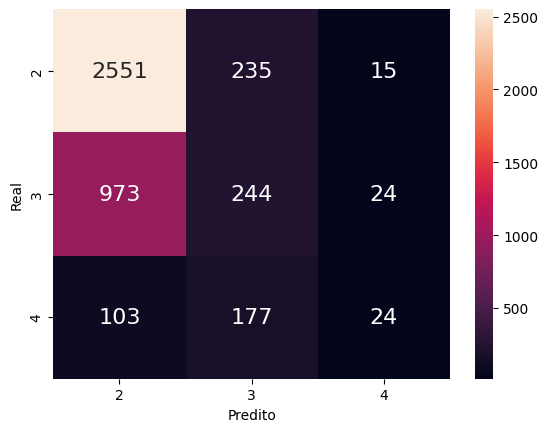

In [37]:
matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)
eixo = sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, fmt="d")
eixo.set(xlabel="Predito", ylabel="Real");

Nessa matriz de confusão, nota-se, novamente, uma quantidade pronunciada de 2 jets e sucesso na sua previsão. Quanto às outras previsões, nota-se que, como no K-NN, o modelo tende a errar quando o número de jets é 3 e 4, principalmente quando é 4. Ou seja, não parece ser um modelo falho, e sim um que não se adequa a dados com tamanha desproporcionalidade.

### Explicação do modelo

Novamente iremos utilizar o `Permutation Importance`.

Importância das features (Permutation Importance):
HT: 0.06639766224444225
Rsq: 0.0025258149314730804
E2: -0.0005554012060604129
Pz1: -0.0006752033679136904
E1: -0.0007924893152754687
Pz2: -0.0010895123003983541
MET: -0.0019786177588286156
Py2: -0.002221794286518519
MR: -0.0023660298160529834
Py1: -0.0033601846616829302
Px1: -0.0035060349014897963
Px2: -0.0036636519123369737


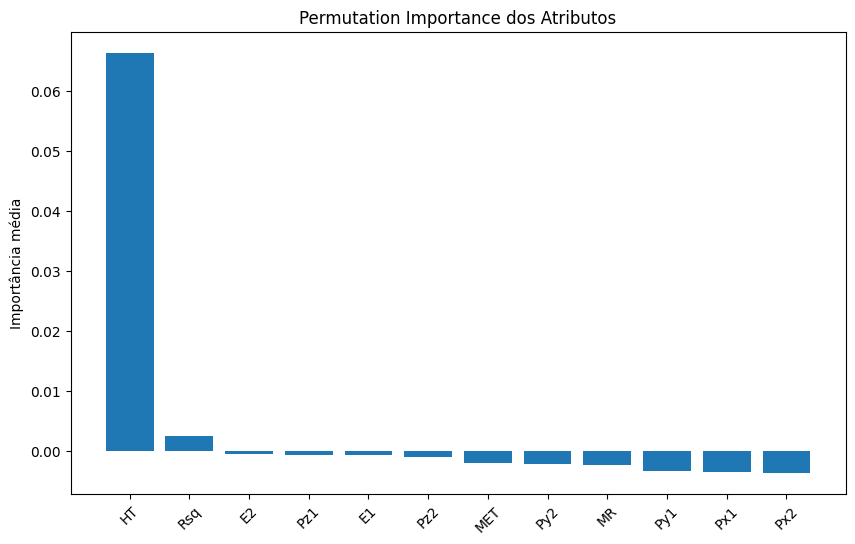

In [38]:
resultado_perm = permutation_importance(
    modelo_rl_pipeline,
    X_teste,
    y_teste,
    n_repeats=5,
    random_state=semente_aleatoria,
    scoring="f1_weighted",
    n_jobs = -1
)
 
importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1]  

tabela_importancia3 = pd.DataFrame({
    "atributo": np.array(atributos)[indices],
    "importancia_media": importancia_atributos[indices]
})
 
print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")
 
plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()

Nesse modelo, novamente o HT se mostrou como o principal atributo. Constatou-se, porém, algo diferente dos outros modelos, que seria atributos com importância de permutação negativa. Isso indica que, ao serem permutados, o desempenho do modelo melhorou. Como nos outros isso não foi constatado, pode-se interpretar esse ocorrido como uma incapacidade do modelo de adequadamente interpretar esses dados.

## Floresta aleatória

O algoritmo da floresta aleatória é baseado em comitê. Seu princípio é utilizar árvores de decisão, sendo que cada uma realiza sua própria previsão [Figura 4]. Sabe-se que a árvore de decisão é um modelo de alto viés e baixa variância. Combinando, porém, diversos desses modelos, objetiva-se encontrar um de baixo viés e alta variância. Ou seja, procura-se um aumento do desempenho desse modelo de comitê em comparação com algum de não o seja.

<figure style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ComicDeath/Proton-Collision-Classifier/main/Figuras/random-forest.jpg" alt="Estrutura comum da Floresta Aleatória" width="600">
  <figcaption><b>Figura 4.</b> Estrutura comum da Floresta Aleatória.</figcaption>
  <br>
  <figcaption><b>Fonte:</b> Julio Cesar Lana - Análise multiescalar dos condicionantes da gênese e evolução de voçorocas nas bacias do Rio das Velhas e do Rio Paraopeba, MG</figcaption>
</figure>
<br>

Seguindo o mesmo princípio de criação 

In [39]:
modelo_rf_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier()
)

### Estimativa de desempenho

Estimando o desempenho inicial utilizando validação cruzada estratificada.

In [40]:
metricas = cross_val_score(
    modelo_rf_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

estimativa_rf = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", estimativa_rf)

Valor do F1_weighted em cada fold: [0.75137284 0.74482291 0.74955443 0.76397199 0.74607087 0.75083091
 0.76999472 0.76341577 0.75900866 0.76690202]
Valor médio 0.7565945119662819


### Otimização utilizando Optuna

Definindo a função que instancia o modelo com trials de hiperparâmetros em uma amplitude de valores desejada.

In [41]:
def cria_instancia_modelo_rf(trial):
    
    parametros_rf = {
        "n_estimators": trial.suggest_int("num_arvores", 5, 300, log=True),
        # Número de árvores na floresta
        
        "criterion": trial.suggest_categorical("criterio", ["gini", "log_loss", "entropy"]),
        # Define a função usada para medir a qualidade de uma divisão. "gini" = índice de Gini, "entropy" = ganho de informação, "log_loss" = logaritmo da perda de entropia
        
        "min_samples_split": trial.suggest_int("min_exemplos_split", 2, 20),
        # Número mínimo de amostras necessárias para dividir um nó interno
        
        "min_samples_leaf": trial.suggest_int("min_exemplos_folha", 1, 20),
        # Número mínimo de amostras que um nó folha deve ter
        
        "max_features": trial.suggest_float("num_max_atributos", 0.0, 1.0),
        # Número máximo de características consideradas para dividir um nó      
          
        "bootstrap": True,
        # Define se o modelo usará amostragem com reposição para gerar subconjuntos de treino (bagging)
        
        "class_weight": "balanced",
        # Peso das classes
        
        "n_jobs": -1,
        
        "random_state": semente_aleatoria,
        # Reprodutibilidade
    }

    modelo = RandomForestClassifier(**parametros_rf)
    
    return modelo

Definindo a função objetivo que testa os diferentes conjuntos de hiperparâmetros e realiza a validação cruzada k-fold.

In [42]:
def objetivo_rf(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_rf(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()


Criando o nosso estudo.

In [43]:
nome_do_estudo = "random_forest_nJets"

study_rf = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///Estudos do Optuna/{nome_do_estudo}.db", 
    load_if_exists=True
)

[I 2025-11-04 08:14:28,054] Using an existing study with name 'random_forest_nJets' instead of creating a new one.


E definindo a função objetivo parcial para a otimização.

In [44]:
def objetivo_parcial_rf(trial):
    return objetivo_rf(trial, X_treino, y_treino, num_folds)

trials_ja_feitos = len(study_rf.trials)
if trials_ja_feitos < num_tentativas:
    study_rf.optimize(objetivo_parcial_rf, n_trials=num_tentativas - trials_ja_feitos)

print("Melhores hiperparâmetros encontrados:")
print(study_rf.best_params)
print(f"Número do melhor trial: {study_rf.best_trial.number}")

Melhores hiperparâmetros encontrados:
{'num_arvores': 218, 'criterio': 'log_loss', 'min_exemplos_split': 5, 'min_exemplos_folha': 2, 'num_max_atributos': 0.9695687798744911}
Número do melhor trial: 72


Devido a um erro na denominação dos hiperparâmetros anterior à realização do estudo, isso foi corrigido da seguinte forma:

In [45]:
params_corrigidos = study_rf.best_trial.params.copy()
 
if "num_arvores" in params_corrigidos:
    params_corrigidos["n_estimators"] = params_corrigidos.pop("num_arvores")
if "criterio" in params_corrigidos:
    params_corrigidos["criterion"] = params_corrigidos.pop("criterio")
if "min_exemplos_split" in params_corrigidos:
    params_corrigidos["min_samples_split"] = params_corrigidos.pop("min_exemplos_split")
if "min_exemplos_folha" in params_corrigidos:
    params_corrigidos["min_samples_leaf"] = params_corrigidos.pop("min_exemplos_folha")
if "num_max_atributos" in params_corrigidos:
    params_corrigidos["max_features"] = params_corrigidos.pop("num_max_atributos")

### Avaliação de desempenho

Avaliamos o desempenho do modelo no conjunto de teste.

In [46]:
modelo_rf_pipeline = make_pipeline(
    StandardScaler(),  
    RandomForestClassifier(**params_corrigidos)
)

modelo_rf_pipeline.fit(X_treino, y_treino)

y_pred = modelo_rf_pipeline.predict(X_teste)

f1_rf_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_rf_final)

F1-score ponderado final: 0.7878621569157607


Observando sua matriz de confusão.

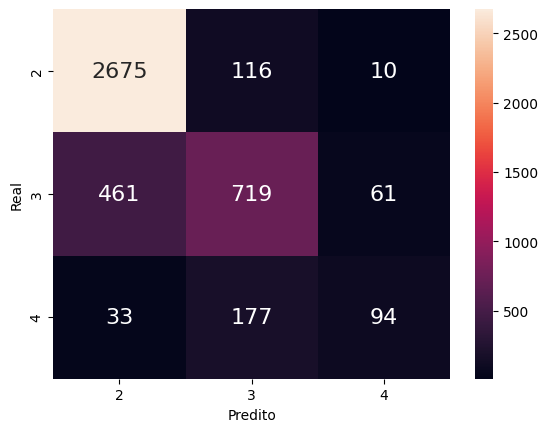

In [47]:
matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)
eixo = sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, fmt="d")
eixo.set(xlabel="Predito", ylabel="Real");

Pela matriz de confusão, nota-se que a floresta aleatória houve uma melhora em relação ao K-NN, regressão logística e árvore de decisões. Isso pois, ao contrário desses modelos, além de tender a acertar a classe 2, também tende a acertar a 3. Além disso, a 4 se mostra melhor contemplada, não sendo, como nos modelos citados, a classe que, mesmo quando verdadeira, é a menos estimada. Dessa forma, a floresta aleatória acabou se adequando melhor a esse dataset desequilibrado.

### Explicação do modelo

Iremos reutilizar o `Permutation Importance` novamente.

Importância das features (Permutation Importance):
HT: 0.31150485264924216
MR: 0.08088053741647208
E1: 0.0409536218116058
Px2: 0.03888920994693081
Py2: 0.03795404441660104
Py1: 0.02855131182756452
Px1: 0.0256211533561006
E2: 0.02222507846649695
Pz1: 0.005020616952350098
Rsq: 0.0037259383263455793
Pz2: 0.003173740560266447
MET: 0.0015614941226691713


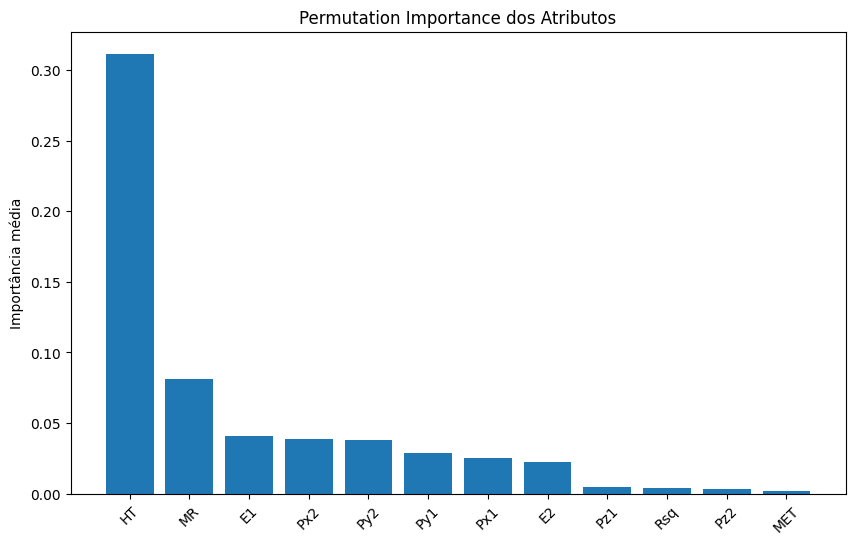

In [48]:
resultado_perm = permutation_importance(
    modelo_rf_pipeline,
    X_teste,
    y_teste,
    n_repeats=5,
    random_state=semente_aleatoria,
    scoring="f1_weighted",
    n_jobs=-1
)
 
importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1]  

tabela_importancia4 = pd.DataFrame({
    "atributo": np.array(atributos)[indices],
    "importancia_media": importancia_atributos[indices]
})
 
print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")
 
plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()

A importância de permutação desses atributos, como nos outros modelos, indicou uma relevância bastante significante do HT. Foi, também, o segundo modelo que apresentou mais atributos além do HT demonstrando algum nível de importância, contribuindo para a já mencionada constatação de que esse modelo soube lidar um pouco melhor com o dataset.

## SVM

O SVM (Support Vector Machine) é um algoritmo de classificação que busca encontrar a melhor fronteira de separação entre diferentes classes nos dados. Essa fronteira, chamada de hiperplano, divide o espaço de atributos de modo a maximizar a distância entre os pontos de diferentes classes, garantindo uma separação mais robusta [Figura 5].

O funcionamento do SVM consiste em analisar todos os exemplos disponíveis e identificar os vetores de suporte, que são os pontos mais próximos do hiperplano e que determinam a posição ótima da fronteira. A partir desses vetores, o algoritmo ajusta o hiperplano para maximizar a margem entre as classes.

<figure style="text-align: center;">
  <img src="https://raw.githubusercontent.com/ComicDeath/Proton-Collision-Classifier/main/Figuras/svm.png" alt="Estrutura comum do SVM" width="600">
  <figcaption><b>Figura 5.</b> Estrutura comum do SVM.</figcaption>
  <br>
  <figcaption><b>Fonte:</b> Riccardo Andreoni - towardsdatascience.com</figcaption>
</figure>
<br>

Induziremos um modelo de SVM classificador (SVC) para prever nJets a partir dos atributos selecionados. Usaremos do mesmo pipeline de antes, que inclui padronização dos dados e a fittagem do modelo. Posteriormente, faremos a otimização dos hiperparâmetros pelo Optuna para obter o melhor desempenho.

In [49]:
modelo_svm_pipeline = make_pipeline(
    StandardScaler(),
    SVC(random_state=semente_aleatoria, class_weight="balanced")
)

### Estimativa de desempenho

Da mesma maneira de antes, iremos usar a validação cruzada `StratifiedKFold` para gerar uma estimativa do desempenho do modelo nos dados de X_treino e y_treino.



In [50]:
metricas = cross_val_score(
    modelo_svm_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

estimativa_svm = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", estimativa_svm)

Valor do F1_weighted em cada fold: [0.79774015 0.79390149 0.78327918 0.78342335 0.7813246  0.78782463
 0.78339284 0.7933292  0.78652956 0.78425381]
Valor médio 0.7874998820794926


### Otimização utilizando Optuna

Da mesma forma que fizemos para a árvore de decisão, utilizaremos do Optuna para otimizar os hiperparâmetros do modelo.

Começamos definindo uma função `cria_instancia_modelo_svm(trial)`, que irá utilizar do Optuna para sugerir valores do Support Vector Classifier.

In [51]:
def cria_instancia_modelo_svm(trial):
    
    parametros_svm = {
        "C": trial.suggest_loguniform("C", 1e-3, 1e3),  
        # Parâmetro de regularização. Valores maiores tentam classificar todos os pontos corretamente, valores menores aumentam a margem.
        
        "kernel": trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"]),  
        # Tipo de kernel usado pelo SVM. "linear" = separação linear, "poly" = polinomial, "rbf" = radial, "sigmoid" = sigmoide.
        
        "degree": trial.suggest_int("degree", 2, 5),  
        # Grau do polinômio (usado apenas se kernel="poly")
        
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),  
        # Coeficiente do kernel para "rbf", "poly" e "sigmoid". "scale" = 1 / (n_features * X.var()), "auto" = 1 / n_features.
        
        "class_weight": "balanced",  
        # Ajusta os pesos das classes para lidar com desbalanceamento
        
        "random_state": semente_aleatoria,  
        # Semente aleatória para reprodutibilidade
    }
    
    modelo = make_pipeline(
        StandardScaler(),
        SVC(**parametros_svm)
    )
    
    return modelo

Agora, desenvolveremos a `função objetivo_svm`, que avalia o desempenho do modelo SVM para diferentes combinações de hiperparâmetros sugeridas pelo Optuna, utilizando validação cruzada e a métrica F1-weighted.



In [52]:
def objetivo_svm(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_svm(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()

Em seguida, vamos criar o objeto de estudo do Optuna, responsável por registrar os resultados da otimização para que possam ser reutilizados posteriormente, evitando a execução repetida do processo.

In [53]:
nome_do_estudo = "svm_nJets"
pasta = "Estudos do Optuna"
caminho_db = f"{pasta}/{nome_do_estudo}"


study_svm = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///{caminho_db}.db", 
    load_if_exists=True
)

[I 2025-11-04 08:20:06,434] Using an existing study with name 'svm_nJets' instead of creating a new one.


Como explicado anteriormente, criaremos a função `objetivo_parcial_svm` para que o Optuna consiga executar o processo de otimização de forma mais simples.



In [54]:
def objetivo_parcial_svm(trial):
    return objetivo_svm(trial, X_treino, y_treino, num_folds)

Executaremos o Optuna para a otimização dos hiperparâmetros, utilizando o número de 100 trials.



In [55]:
trials_ja_feitos = len(study_svm.trials)
if trials_ja_feitos < num_tentativas:
    study_svm.optimize(objetivo_parcial_svm, n_trials=num_tentativas - trials_ja_feitos)

In [56]:
print("Melhores hiperparâmetros encontrados:")
print(study_svm.best_params)
print(f"Número do melhor trial: {study_svm.best_trial.number}")
print(f"Melhor valor de F1: {study_svm.best_value}")

Melhores hiperparâmetros encontrados:
{'C': 98.58836215851876, 'kernel': 'rbf', 'degree': 3, 'gamma': 'auto'}
Número do melhor trial: 52
Melhor valor de F1: 0.8648376160761477


### Avaliação de desempenho

Montaremos agora o pipeline da avaliação final de desempenho.

In [57]:
modelo_svm_pipeline = make_pipeline(
    StandardScaler(),  
    SVC(random_state=semente_aleatoria, **study_svm.best_trial.params, class_weight="balanced")
)

modelo_svm_pipeline.fit(X_treino, y_treino)

y_pred = modelo_svm_pipeline.predict(X_teste)

f1_svm_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_svm_final)

F1-score ponderado final: 0.8694481644494442


Também podemos observar a matriz de confusão.

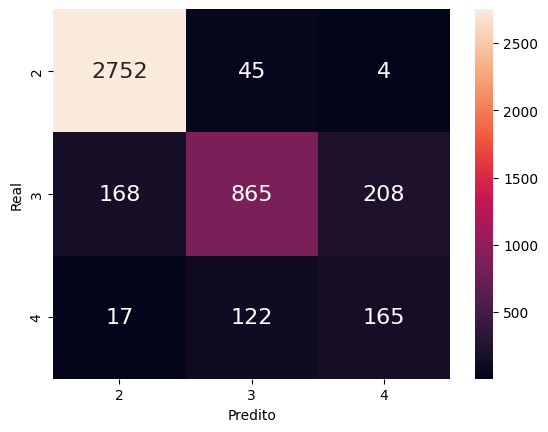

In [58]:
matriz_conf = confusion_matrix(y_teste, y_pred, labels=ordem_labels)
df_conf = pd.DataFrame(matriz_conf, ordem_labels, ordem_labels)
eixo = sns.heatmap(df_conf, annot=True, annot_kws={"size": 16}, fmt="d")
eixo.set(xlabel="Predito", ylabel="Real");
 

Observa-se que o SVM apresentou excelente desempenho para as classes 2 e 3, enquanto o desempenho para a classe 4 foi intermediário.

### Explicação do modelo

Iremos utilizar novamente o `Permutation Importance`

Importância das features (Permutation Importance):
HT: 0.43117561210839617
E1: 0.34468980812074695
E2: 0.3286901544773813
Px1: 0.2929252779990833
Pz2: 0.29069851585582307
Pz1: 0.2857192051682061
Px2: 0.28479674957581025
Py1: 0.2821248859082532
Py2: 0.2749117446806911
MR: 0.21154917855422392
Rsq: 0.031664695706145586
MET: 0.02172264677231821


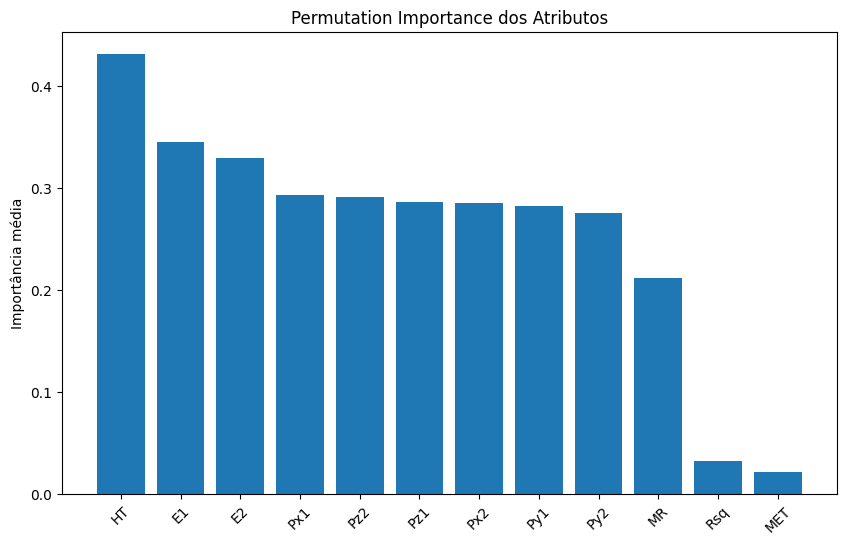

In [59]:
resultado_perm = permutation_importance(
    modelo_svm_pipeline,
    X_teste,
    y_teste,
    n_repeats=5,
    random_state=semente_aleatoria,
    scoring="f1_weighted",
    n_jobs=-1
)

importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1] 

tabela_importancia5 = pd.DataFrame({
    "atributo": np.array(atributos)[indices],
    "importancia_media": importancia_atributos[indices]
})

print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")

plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()

Embora a variável HT tenha apresentado a maior importância média, a distribuição de importância entre os atributos no SVM mostra-se relativamente equilibrada, sugerindo que não há um único fator dominante. Esse comportamento contrasta com os demais modelos, nos quais o HT concentrava a maior parte da influência sobre a previsão, enquanto outros atributos tinham participação muito inferior.

## Baseline

Para estabelecer um ponto de referência, foi criado um modelo baseline simples com a estratégia `uniform`, cuja função é fornecer uma métrica base de desempenho.

In [60]:
baseline_pipeline = make_pipeline(
    StandardScaler(),
    DummyClassifier(strategy="most_frequent", random_state=semente_aleatoria)
)

baseline_pipeline.fit(X_treino, y_treino)

y_pred = baseline_pipeline.predict(X_teste)

f1_baseline_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_baseline_final)

F1-score ponderado final: 0.5051759993009852


# Discussão dos resultados

Discutiremos os resultados obtidos neste trabalho de forma geral.

 Iniciamos pela comparação entre as estimativas de desempenho dos modelos antes da otimização e a avaliação final após a otimização de hiperparâmetros, destacando a mudança do F1-weighted.

In [61]:
dados = {
    "Modelo": ["Árvore de Decisão", "KNN", "Regressão Logística", "Floresta Aleatória", "SVM"],
    "Estimativa": [estimativa_ad, estimativa_knn, estimativa_rl, estimativa_rf, estimativa_svm],
    "F1-score ponderado final": [f1_ad_final, f1_knn_final, f1_rl_final, f1_rf_final, f1_svm_final]
}

tabela_resultados = pd.DataFrame(dados)

print(tabela_resultados)

                Modelo  Estimativa  F1-score ponderado final
0    Árvore de Decisão    0.705257                  0.713545
1                  KNN    0.653742                  0.655304
2  Regressão Logística    0.608065                  0.594156
3   Floresta Aleatória    0.756595                  0.787862
4                  SVM    0.787500                  0.869448


Visando avaliar a eficácia do `Optuna` em encontrar o conjunto de hiperparâmetros que melhor otimiza o desempenho do modelo, abaixo estão os dados com o valor do F1-score ponderado antes e depois desse processo de otimização. Vale ressaltar que o desempenho anterior à otimização foi avaliado por validação cruzada.
 
A árvore de decisão, o K-NN e a floresta aleatória demonstraram uma melhora, por mais que pequena, do F1-score, indicando modelos já no seus limites de adequação.
 
A regressão logística apresentou algo inesperado, que seria a diminuição do F1-score. Supõe-se que isso possa ter ocorrido por o `optuna` ter encontrado um conjunto otimizado, porém que não seguia a real tendência dos dados, ocasionando uma redução de desempenho. Ou seja, esse aparenta ser um caso de _overfitting_.
 
Já o SVM foi o modelo que mais se beneficiou da otimização, tendo seu desempenho aumentado de forma bastante evidente e significativa, levando-o a alcançar um desempenho excepcional, bastante distante daqueles dos demais modelos.

------------------------------------------------------------------------------------------------------------------------

Em seguida, será feita a comparação do desempenho final entre os diferentes modelos, incluindo o baseline. Essa etapa permite avaliar quais algoritmos obtiveram melhor capacidade preditiva após a otimização e como eles se comparam com a referência de base.

In [62]:
dados = {
    "Modelo": ["Baseline", "Árvore de Decisão", "KNN", "Regressão Logística", "Floresta Aleatória", "SVM"],
    "F1-score ponderado final": [f1_baseline_final, f1_ad_final, f1_knn_final, f1_rl_final, f1_rf_final, f1_svm_final]
}

modelos_resultados = pd.DataFrame(dados)

modelos_resultados = modelos_resultados.sort_values(by="F1-score ponderado final", ascending=False).reset_index(drop=True)

print(modelos_resultados)

                Modelo  F1-score ponderado final
0                  SVM                  0.869448
1   Floresta Aleatória                  0.787862
2    Árvore de Decisão                  0.713545
3                  KNN                  0.655304
4  Regressão Logística                  0.594156
5             Baseline                  0.505176


Tomando como referência desempenho do baseline, sabe-se que todos os modelos, por apresentarem desempenho maior, se mostraram satisfatórios. Dentre eles, o pior seria o da regressão logística, cujas evidências de _overfitting_ e comportamento inesperado do desempenho indicam que não seja adequado para esse dataset, o que é esperado, considerando que os dados sendo analisados não seguem padrões lineares.
 
Em ordem de pior para melhor desempenho, os modelos com os algoritmos K-NN, árvore de decisão e floresta aleatória obtiveram um afastamento perceptível do baseline.
 
Já o SVM, foi o modelo que apresentou maior desempenho, excelente não só em relação ao baseline, mas também ao segundo melhor dentre esses modelos. Isso aponta o SVM como um modelo que lidou bem com esse dataset e que foi capaz de treiná-lo de forma a fazer boas previsões sem que se desconfie que a razão por trás disso seja os próprios dados.

------------------------------------------------------------------------------------------------------------------------

Passaremos, então, à discussão das diferentes importâncias de cada atributo, com base nos resultados obtidos pela técnica de `Permutation Importance`. Essa análise permite identificar quais variáveis tiveram maior influência nas previsões de cada modelo, evidenciando como cada algoritmo interpreta e utiliza as informações presentes nos dados.

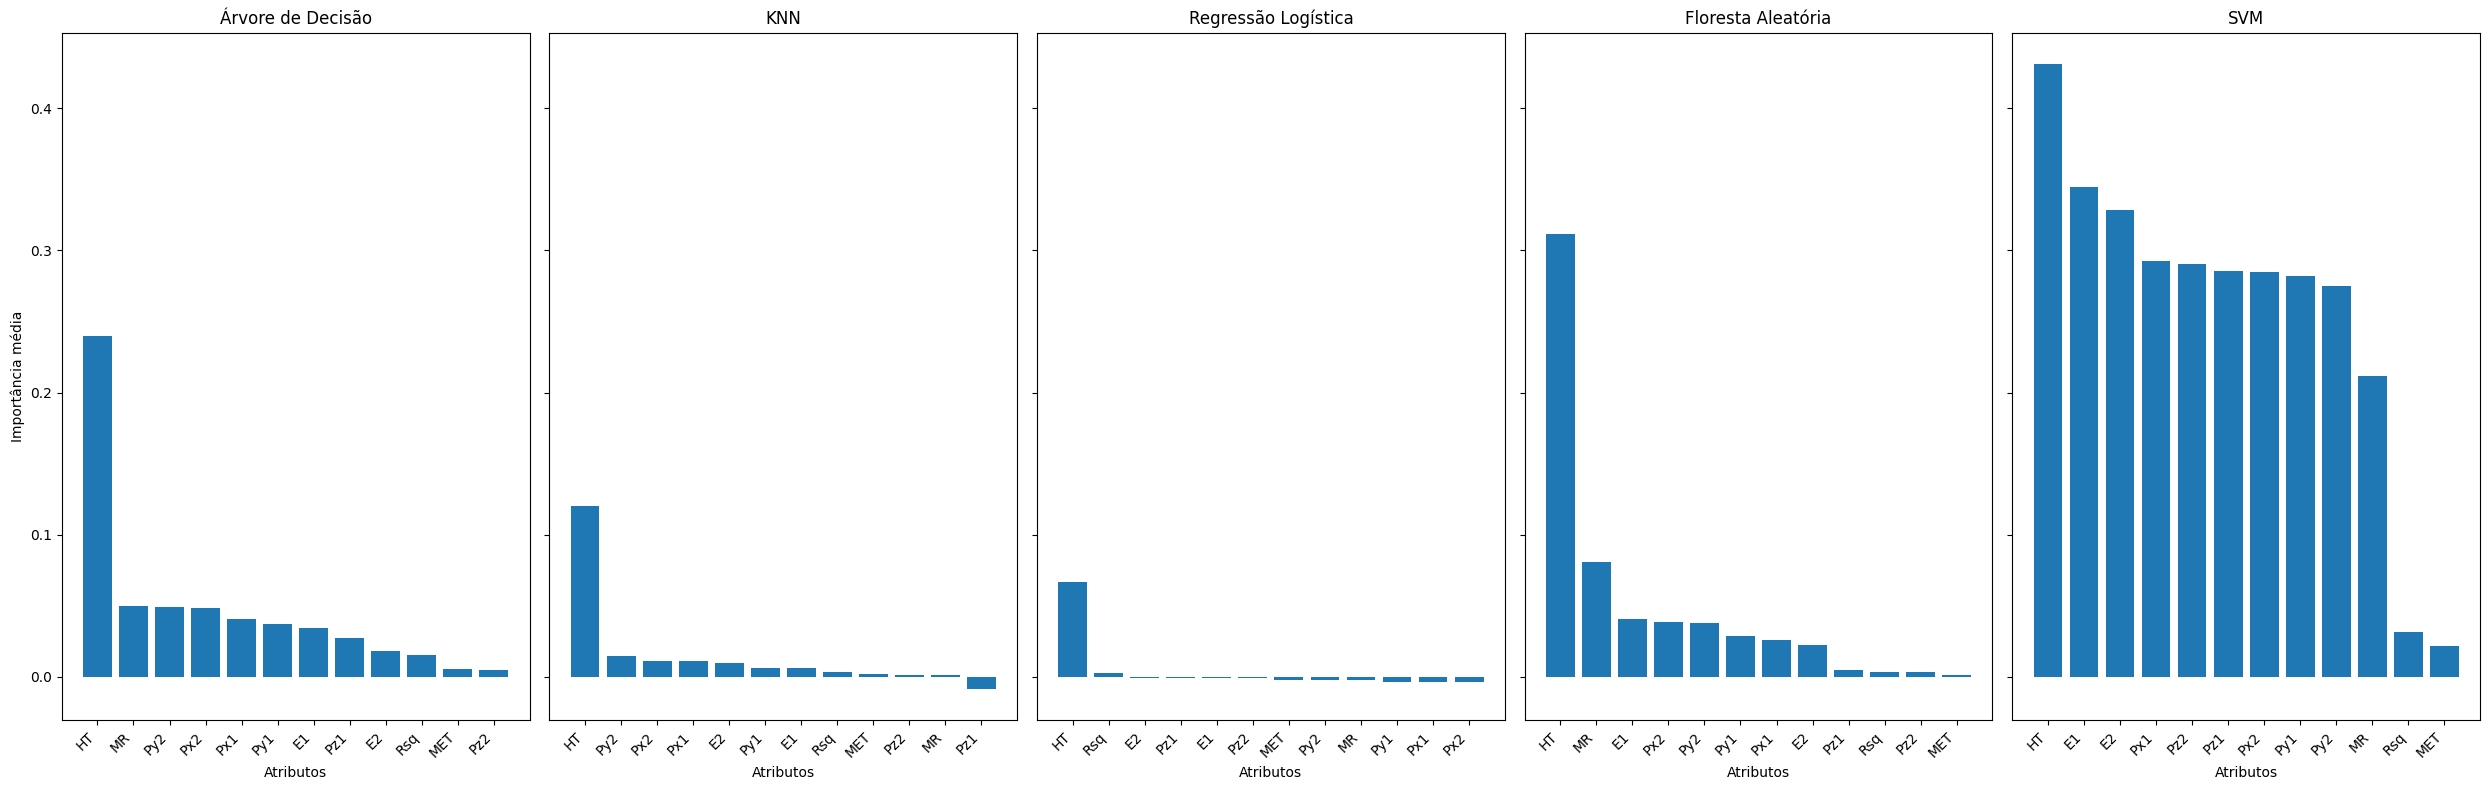

In [63]:
fig, axs = plt.subplots(1, 5, figsize=(25, 8), sharey=True)

tabelas = [
    (tabela_importancia1, "Árvore de Decisão"),
    (tabela_importancia2, "KNN"),
    (tabela_importancia3, "Regressão Logística"),
    (tabela_importancia4, "Floresta Aleatória"),
    (tabela_importancia5, "SVM"),
]

for ax, (tabela, titulo) in zip(axs, tabelas):
    ax.bar(tabela["atributo"], tabela["importancia_media"])
    ax.set_title(titulo)
    ax.set_xlabel("Atributos")
    ax.set_xticks(range(len(tabela["atributo"])))
    ax.set_xticklabels(tabela["atributo"], rotation=45, ha="right")

axs[0].set_ylabel("Importância média")

plt.tight_layout()
plt.show()

A Permutation Importance é um grande indicador de que o elevado desempenho dos 4, principalmente dos 3, primeiros pode se dever à predominância de um único target, enviesando o modelo a prevê-lo com maior frequência. Como o teste também provém desse dataset desproporcional, o desempenho se torna elevado, mesmo tentando contar isso com validação cruzada estratificada e hiperparâmetro de balanceamento de peso. Essa possibilidade é reforçada pelas matrizes de confusão obtidas, indicando que, por mais que o modelo erre praticamente toda classe que não seja a predominante, a principal está em tamanha quantidade que o desempenho se mostrará elevado.

Já a floresta aleatória e o SVM não parecem estar conforme essa observação, já que ambos mostraram uma significância de outros atributos além de um único (principalmente o SVM, que chegou em uma disposição aparentemente bem distribuida deles). Por serem também os dois modelos de maior desempenho, depreende-se que se foram capazes de lidar com a desproporcionalidade dos dados.

## Conclusão

Nessa quest, através do treinamento de 5 diferentes modelos de aprendizados de máquinas e maneiras de otimizá-los, procurou-se prever o número de jets liberados em uma colisão de prótons. O dataset, por ser bastante desproporcional ao apresentar uma classe de extrema predominância em relação às outras, demandou que, ao serem aplicadas estratégias como a de validação cruzada e avaliação do desempenho via F1-score, fosse necessário levar em conta essa distribuição dos dados por validação estratificada e F1-score com pesos.
 
Essa característica aparentou ser um impasse para o bom desempenho da regressão logística, do K-NN e da árvore de decisões, os três mostrando uma importância de atributos com apenas um atributo dominante e matrizes de confusão evidenciando que o número bom de seu desempenho não estava condizente com a sua capacidade de prever diferentes classes, sendo uma consequência da alta frequência de uma em particular. Todos os modelos, inclusive, obtiveram desempenhos maiores que o do baseline, a maioria desses sendo incrementada pela otimização de hiperparâmetros via `optuna`.
 
Por fim, ficou claro que o algoritmo SVM resultou no melhor modelo, o único que não pareceu ser tão enviesado pelo dataset desigual. Esse também foi aquele com o maior aumento de desempenho pós otimização, se mostrando bastante promissor e adequado para a análise aqui proposta.
 

## Referências

CASSAR, Daniel. ATP-203 1.1 - Tratamento de dados

CASSAR, Daniel. ATP-203 2.0 - Tipos de aprendizado de máquina e algoritmo k-NN

CASSAR, Daniel. ATP-203 2.1 - Aprendizado de máquina, k-NN e métricas

CASSAR, Daniel. ATP-203 3.0 - Modelo linear e baseline

CASSAR, Daniel. ATP-203 4.0 - Split de dados de treino e teste

CASSAR, Daniel. ATP-203 4.1 - Árvore de decisão

CASSAR, Daniel. ATP-203 5.0 - Validação cruzada, busca aleatória e busca em grade

CASSAR, Daniel. ATP-203 5.1 - Floresta aleatória

CASSAR, Daniel. ATP-203 6.0 - Desempacotando listas e dicionários com operadores estrela

CASSAR, Daniel. ATP-203 6.1 - Otimização de hiperparâmetros com optuna

CASSAR, Daniel. ATP-203 7.0 - Dados sintéticos e pipeline

CASSAR, Daniel. ATP-203 7.1 - Seleção de atributos

CASSAR, Daniel. ATP-203 7.0 - Dados sintéticos e pipeline

CASSAR, Daniel. ATP-203 8.0 - A matriz de covariância e a matriz de correlação

CASSAR, Daniel. ATP-203 9.0 - Tratamento de exceções

CASSAR, Daniel. ATP-203 9.1 - Classificação binária

CASSAR, Daniel. ATP-203 10.0 - Outras métricas de classificação

CASSAR, Daniel. ATP-203 10.1 - Classificação multiclasse

Scikit-Learn. DecisionTreeClassifier. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Scikit-Learn. KNeighborsClassifier. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Scikit-Learn. LogisticRegression. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Scikit-Learn. RandomForestClassifier. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Scikit-Learn. SVC (Support Vector Classifier). Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Optuna. Documentação oficial do Optuna. Disponível em: https://optuna.readthedocs.io/en/stable/